In [1]:
# Install dependencies
!pip install deepface tensorflow opencv-python keras-vggface scikit-learn matplotlib gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b79291203b1c53f9ec4e51a303a56a0374a4a370b34a86f5b8b397587495e584
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile, os, cv2, numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import flatten, sum
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')from deepface import DeepFace
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import os

## **Problem Statement 1: Face Mask Detection for Movie Cast Information**

Context: Company X wants to automate cast info by detecting face masks in movie scene screenshots.

Dataset: Images and masks in Images.npy.

Objective: Build a face detection system using mask prediction.

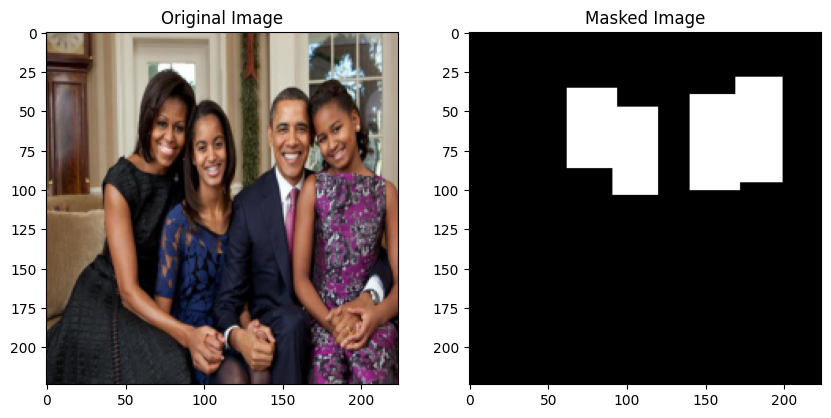

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/150


In [ ]:
# Step 1A: Import and read ‘Images.npy’ [1 Mark]
data = np.load('/content/drive/My Drive/PGPDLAI-DEC24/CV Project/Images.npy', allow_pickle=True)
IMG_SIZE = (224, 224)

# Step 1B: Split the data into Features(X) & labels(Y), unify shape [3 Marks]
X = []
Y = []
for i, sample in enumerate(data):
    img, mask = sample[0], sample[1]
    if isinstance(img, list):
        img = np.array(img, dtype=np.float32)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    elif img.shape[-1] != 3:
        raise ValueError(f"Image at index {i} has unexpected shape: {img.shape}")

    mask_array = np.zeros(img.shape[:2], dtype=np.uint8)
    if isinstance(mask, list) and any(isinstance(m, dict) for m in mask):
        for coord in mask:
            points = coord.get('points', [])
            if len(points) == 2:
                x1_norm = points[0].get('x', 0)
                y1_norm = points[0].get('y', 0)
                x2_norm = points[1].get('x', 0)
                y2_norm = points[1].get('y', 0)
                img_width = coord.get('imageWidth', img.shape[1])
                img_height = coord.get('imageHeight', img.shape[0])
                x1 = int(x1_norm * img_width)
                y1 = int(y1_norm * img_height)
                x2 = int(x2_norm * img_width)
                y2 = int(y2_norm * img_height)
                x = min(x1, x2)
                y = min(y1, y2)
                w = abs(x2 - x1)
                h = abs(y2 - y1)
                x_end = min(x + w, img.shape[1])
                y_end = min(y + h, img.shape[0])
                x = max(x, 0)
                y = max(y, 0)
                if x_end > x and y_end > y:
                    mask_array[y:y_end, x:x_end] = 1

    img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask_array, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    img_resized = img_resized / 255.0
    mask_resized = np.where(mask_resized > 0, 1, 0).astype(np.uint8)
    mask_resized = np.expand_dims(mask_resized, axis=-1)

    X.append(img_resized)
    Y.append(mask_resized)

X = np.array(X)
Y = np.array(Y)

# Step 1C: Split the data into train and test [70:30] [1 Mark]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Step 1D: Display original and masked image from train data [2 Marks]
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(Y_train[idx].squeeze(), cmap='gray')
plt.title("Masked Image")
plt.show()

# Step 2A: Design a face mask detection model (MobileNet U-Net) [4 Marks]
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=inputs)
base_model.trainable = True
for layer in base_model.layers[:40]:
    layer.trainable = False

skip_layers = [
    base_model.get_layer('conv_pw_11_relu').output,
    base_model.get_layer('conv_pw_5_relu').output,
    base_model.get_layer('conv_pw_3_relu').output
]

x = base_model.output
x = UpSampling2D((2, 2))(x)
x = Conv2D(384, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = Concatenate()([x, skip_layers[0]])
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = Concatenate()([x, skip_layers[1]])
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = Concatenate()([x, skip_layers[2]])
x = UpSampling2D((4, 4))(x)
x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

model = Model(inputs, x)

# Step 2B: Design Dice Coefficient and Loss function [2 Marks]
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = flatten(tf.cast(y_true, tf.float32))
    y_pred_f = flatten(tf.cast(y_pred, tf.float32))
    intersection = sum(y_true_f * y_pred_f)
    union = sum(y_true_f) + sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Step 2C: Train and tune the model [3 Marks]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=2e-4, decay_steps=2000, decay_rate=0.9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=dice_loss, metrics=[dice_coefficient])

callbacks = [EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
history = model.fit(train_dataset, validation_data=val_dataset, epochs=150, callbacks=callbacks)

# Step 2D: Evaluate and share insights on performance [2 Marks]
test_loss, test_dice = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Dice Coefficient: {test_dice:.4f}")
test_pred = model.predict(X_test)
pure_loss = dice_loss(Y_test, test_pred)
print(f"Pure Dice Loss: {pure_loss:.4f}")

# Step 3: Test model predictions on test image (index 3) and visualize [2 Marks]
test_idx = 3
test_image = X_test[test_idx:test_idx+1]
pred_mask = model.predict(test_image)
pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_image[0])
plt.title("Test Image")
plt.subplot(1, 3, 2)
plt.imshow(Y_test[test_idx].squeeze(), cmap='gray')
plt.title("True Mask")
plt.subplot(1, 3, 3)
plt.imshow(pred_mask_binary[0].squeeze(), cmap='gray')
plt.title("Predicted Mask (Threshold 0.5)")
plt.show()

## **Problem Statement 2: Face Detection for Movie Cast Information (Haar Cascade)**

Context: Company X wants to automate cast and crew information in movie scenes using face detection on screenshots.

Dataset: Face images in training_images folder.

Objective: Create an image dataset for an AI classifier by detecting faces and saving metadata.

In [ ]:
# Step 1: Read/import images from folder ‘training_images’ [2 Marks]
folder_path = '/content/drive/My Drive/PGPDLAI-DEC24/CV Project/training_images'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Total images found: {len(image_files)}")

# Step 2: Write a loop to iterate through all images and detect faces [3 Marks]
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_data = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load: {image_path}")
        continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    print(f"Detected {len(faces)} faces in {image_file}")

# Step 3: Extract metadata of the faces and write into a DataFrame [3 Marks]
    for (x, y, w, h) in faces:
        face_metadata = {
            'image_file': image_file,
            'x': x,
            'y': y,
            'width': w,
            'height': h
        }
        face_data.append(face_metadata)

df = pd.DataFrame(face_data)
print("Face metadata shape:", df.shape)
print(df.head())

# Step 4: Save the output DataFrame in .csv format [2 Marks]
df.to_csv('/content/face_metadata.csv', index=False)
print("Saved to '/content/face_metadata.csv'")

## **Problem Statement 3: Face Recognition with PINS Dataset**

Context: Company X aims to build a face identification model using the PINS dataset.

Dataset: 10,770 aligned face images of 100 people (PINS.zip).

Objective: Develop a face recognition model with embeddings, distance metrics, PCA, and SVM.

In [ ]:
# Step 1: Unzip, read and load data (‘PINS.zip’) into session [2 Marks]
zip_path = '/content/drive/My Drive/PGPDLAI-DEC24/CV Project/PINS.zip'
extract_path = '/content/pins_dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
pins_path = os.path.join(extract_path, 'PINS')

image_files = []
seen_names = set()
for root, dirs, files in os.walk(pins_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(root, file)
            file_name = os.path.basename(full_path)
            if file_name not in seen_names:
                image_files.append(full_path)
                seen_names.add(file_name)
print(f"Total unique images loaded: {len(image_files)}")

# Step 2: Write function to create metadata of the image [4 Marks]
def create_metadata(image_path):
    file_name = os.path.basename(image_path)
    person_label = os.path.basename(os.path.dirname(image_path)).replace('pins_', '')
    return {'file_path': image_path, 'file_name': file_name, 'person_label': person_label}

# Step 3: Write a loop to iterate through each image and create metadata [4 Marks]
metadata_df = pd.DataFrame([create_metadata(img) for img in image_files])
print("Metadata shape:", metadata_df.shape)

# Step 4: Generate embedding vectors on each face in the dataset [4 Marks]
def get_face_embedding(image_path):
    try:
        return np.array(DeepFace.represent(img_path=image_path, model_name='VGG-Face', detector_backend='skip')[0]["embedding"])
    except Exception as e:
        print(f"Failed to process {image_path}: {e}")
        return np.zeros(4096)

batch_size = 500
embeddings_file = '/content/embeddings.pkl'
if not os.path.exists(embeddings_file):
    embeddings = []
    for i in range(0, len(metadata_df), batch_size):
        batch = metadata_df['file_path'][i:i+batch_size]
        batch_embeddings = np.array([get_face_embedding(img) for img in batch])
        embeddings.append(batch_embeddings)
        print(f"Processed batch {i//batch_size + 1}/{len(metadata_df)//batch_size + 1}")
    embeddings = np.vstack(embeddings)
    with open(embeddings_file, 'wb') as f:
        pickle.dump(embeddings, f)
else:
    with open(embeddings_file, 'rb') as f:
        embeddings = pickle.load(f)
print("Embeddings shape:", embeddings.shape)

# Step 5: Build distance metrics for similar and dissimilar images [4 Marks]
def compute_distance(embedding1, embedding2):
    if np.all(embedding1 == 0) or np.all(embedding2 == 0):
        return float('nan')
    return cosine(embedding1, embedding2)
dist = compute_distance(embeddings[0], embeddings[1])
print(f"Sample distance: {dist}")

# Step 6: Use PCA for dimensionality reduction [2 Marks]
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)
print("PCA embeddings shape:", embeddings_pca.shape)

# Step 7: Build an SVM classifier to map each image to its right person [4 Marks]
y = metadata_df['person_label'].values
X_train, X_test, y_train, y_test = train_test_split(embeddings_pca, y, test_size=0.2, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
print(f"SVM accuracy: {svm.score(X_test, y_test):.4f}")

# Step 8: Import and display the test images [2 Marks]
test_images = ['Benedict Cumberbatch9.jpg', 'Dwayne Johnson4.jpg']
test_paths = [f for img in test_images for f in image_files if img in f]
for test_path in test_paths:
    img = cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(os.path.basename(test_path))
    plt.axis('off')
    plt.show()

# Step 9: Use the trained SVM model to predict the face on both test images [4 Marks]
test_embeddings = [get_face_embedding(tp) for tp in test_paths]
test_embeddings_pca = pca.transform(test_embeddings)
predictions = svm.predict(test_embeddings_pca)
for i, pred in enumerate(predictions):
    print(f"Test image: {test_images[i]}, Predicted: {pred}")